In [35]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report

In [36]:
#import splitfolders
#splitfolders.ratio('Test', output="output", seed=1337, ratio=(0.5,0.5)) 

In [37]:
#Load base model
base_model=MobileNet(weights='imagenet',include_top=False)

In [38]:
#Add new layers
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x)

In [39]:
model=keras.Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, None, None, 512)  4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_pw_9 (Conv2D)          (None, None, None, 512)   262144    
                                                                 
 conv_pw_9

In [40]:
# Assign Trainable layers and freeze layer -> ลองเปลี่ยน ช่วง layer ในการ trainable True/False 3 ค่า เพื่อดูความแตกต่างของผลลัพธ์ที่ได้
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [41]:
#Create DataGeneartor Object
datagen=ImageDataGenerator( rescale=1./255,
rotation_range=30, zoom_range=0.5,
width_shift_range=0.2, height_shift_range=0.2,
shear_range=0.15, horizontal_flip=True,
fill_mode="nearest")

In [42]:
# Create Train Image generator
train_generator = datagen.flow_from_directory(
    directory="./train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 97 images belonging to 3 classes.


In [43]:
# Create Validation Image generator
val_generator=datagen.flow_from_directory("./validate/", # this is where you specify the path to the main data folder
target_size=(224,224), color_mode='rgb',
batch_size=20,
class_mode="categorical", seed = 42,
shuffle=True)

Found 69 images belonging to 3 classes.


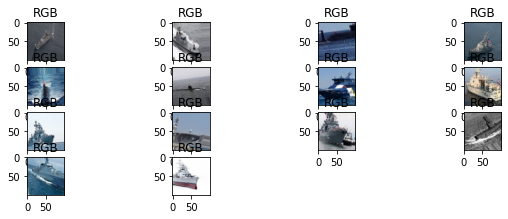

In [44]:
batch = train_generator.next()
Img_train = (batch[0]*255)
plt.figure(figsize=(10,4))
for i in range(1,15):
    plt.subplot(5,4,i)
    plt.imshow(Img_train[i-1].astype("uint8"))
    plt.title('RGB')

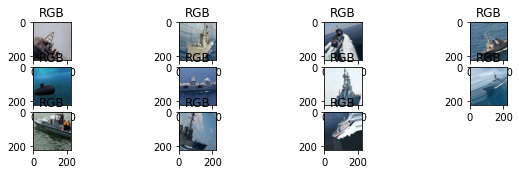

In [45]:
batch = val_generator.next()
Img_train = (batch[0]*255)
plt.figure(figsize=(10,4))
for i in range(1,12):
    plt.subplot(5,4,i)
    plt.imshow(Img_train[i-1].astype("uint8"))
    plt.title('RGB')

In [46]:
#Create Optimizer
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [47]:
# Define training Generator Parameter
EP = 5 # Number of Epoches
step_size_train=train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size
# check step_size_Train = step_size_val -> if not adjust batch_size to make it equal
print(f"step_size_train = {step_size_train} step_size_val = {step_size_val}")

step_size_train = 3 step_size_val = 3


In [48]:
history=model.fit_generator(generator=train_generator,
    steps_per_epoch=step_size_train,
    validation_data = val_generator,
    validation_steps = step_size_val,
    epochs=EP,
    verbose = 1)

Epoch 1/5


C:\Users\ryu\AppData\Local\Temp\ipykernel_13548\2098572540.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=train_generator,


3/3 [==============================] - 4s 995ms/step - loss: 2.7071 - accuracy: 0.2615 - val_loss: 1.8465 - val_accuracy: 0.2833
Epoch 2/5
3/3 [==============================] - 2s 656ms/step - loss: 1.5473 - accuracy: 0.3538 - val_loss: 1.6239 - val_accuracy: 0.3167
Epoch 3/5
3/3 [==============================] - 2s 680ms/step - loss: 1.1253 - accuracy: 0.4615 - val_loss: 1.4423 - val_accuracy: 0.3333
Epoch 4/5
3/3 [==============================] - 2s 711ms/step - loss: 1.1484 - accuracy: 0.4271 - val_loss: 1.6323 - val_accuracy: 0.2833
Epoch 5/5
3/3 [==============================] - 2s 738ms/step - loss: 0.8180 - accuracy: 0.6354 - val_loss: 1.2915 - val_accuracy: 0.5333


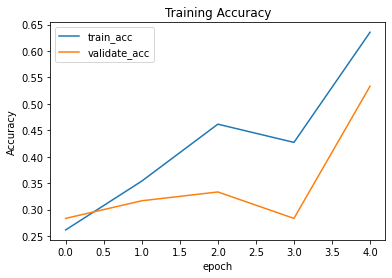

In [49]:
# Performance Visualization
# View Accuracy (Training, Validation)
plt.plot(history.history["accuracy"], label="Train_acc")
plt.plot(history.history["val_accuracy"], label="Validate_acc")
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'validate_acc'], loc='upper left')

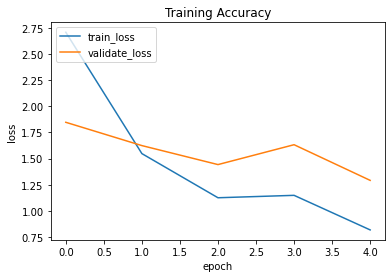

In [50]:
# View Loss (Training, Validation)
plt.plot(history.history['loss'], label="Train_loss")
plt.plot(history.history['val_loss'], label="Validate_loss")
plt.title('Training Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validate_loss'], loc='upper left')

In [51]:
# Initial test generator
test_datagen= ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
"./test/",
class_mode="categorical",
target_size=(224, 224), color_mode="rgb",
shuffle=False, seed=42,
batch_size=5)

Found 15 images belonging to 3 classes.


In [52]:
#Get class id for y_real_class
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

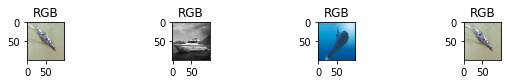

In [53]:
plt.figure(figsize=(10,4))
for i in range(1,5):
    batch = test_generator.next()
    Img_train = (batch[0]*255)
    plt.subplot(5,4,i)
    plt.imshow(Img_train[0].astype("uint8"))
    plt.title('RGB')

In [60]:
#predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred_prob = []
pred=model.predict_generator(test_generator)
for i in range(len(y_true)):
    pred_prob.append(np.array(pred[i]))

C:\Users\ryu\AppData\Local\Temp\ipykernel_13548\2625963933.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_generator)


In [61]:
#Get classID from max prob(pred_prob)
df_pred = pd.DataFrame(pred_prob)
df_pred

,0,1,2
0,0.659491,0.326643,0.013866
1,0.509602,0.487091,0.003307
2,0.529782,0.462254,0.007964
3,0.620963,0.360890,0.018148
4,0.614420,0.378776,0.006804
5,0.323939,0.670165,0.005896
6,0.475294,0.513425,0.011281
7,0.562901,0.423618,0.013481
8,0.352341,0.634024,0.013635
9,0.498798,0.488062,0.013140


In [62]:
df_class = df_pred.idxmax(axis=1)
df_class

0     0
1     0
2     0
3     0
4     0
5     1
6     1
7     0
8     1
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

In [63]:
print(confusion_matrix(y_true, df_class))

print(classification_report(y_true, df_class))

[[4 0 0]
 [3 3 0]
 [5 0 0]]
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.50      0.67         6
           2       0.00      0.00      0.00         5

    accuracy                           0.47        15
   macro avg       0.44      0.50      0.39        15
weighted avg       0.49      0.47      0.40        15



C:\Users\ryu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ryu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ryu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
#import splitfolders
#splitfolders.ratio('Test', output="output", seed=1337, ratio=(0.5,0.5)) 

In [ ]:
#Load base model
base_model=MobileNet(weights='imagenet',include_top=False)

In [ ]:
#Add new layers
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(131,activation='softmax')(x)

In [ ]:
model=keras.Model(inputs=base_model.input,outputs=preds)
model.summary()

In [ ]:
# Assign Trainable layers and freeze layer -> ลองเปลี่ยน ช่วง layer ในการ trainable True/False 3 ค่า เพื่อดูความแตกต่างของผลลัพธ์ที่ได้
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [ ]:
#Create DataGeneartor Object
datagen=ImageDataGenerator( rescale=1./255,
rotation_range=30, zoom_range=0.5,
width_shift_range=0.2, height_shift_range=0.2,
shear_range=0.15, horizontal_flip=True,
fill_mode="nearest")

In [ ]:
# Create Train Image generator
train_generator = datagen.flow_from_directory(
    directory="./output/train/",
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=131,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

In [ ]:
# Create Validation Image generator
val_generator=datagen.flow_from_directory("./output/validate/", # this is where you specify the path to the main data folder
target_size=(100,100), color_mode='rgb',
batch_size=22,
class_mode="categorical", seed = 42,
shuffle=True)

In [ ]:
batch = train_generator.next()
Img_train = (batch[0]*255)
plt.figure(figsize=(10,4))
for i in range(1,15):
    plt.subplot(5,4,i)
    plt.imshow(Img_train[i-1].astype("uint8"))
    plt.title('RGB')

In [ ]:
batch = val_generator.next()
Img_train = (batch[0]*255)
plt.figure(figsize=(10,4))
for i in range(1,12):
    plt.subplot(5,4,i)
    plt.imshow(Img_train[i-1].astype("uint8"))
    plt.title('RGB')

In [ ]:
#Create Optimizer
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Define training Generator Parameter
EP = 5 # Number of Epoches
step_size_train=train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size
# check step_size_Train = step_size_val -> if not adjust batch_size to make it equal
print(f"step_size_train = {step_size_train} step_size_val = {step_size_val}")

In [ ]:
history=model.fit_generator(generator=train_generator,
    steps_per_epoch=step_size_train,
    validation_data = val_generator,
    validation_steps = step_size_val,
    epochs=EP,
    verbose = 1)

In [ ]:
# Performance Visualization
# View Accuracy (Training, Validation)
plt.plot(history.history["accuracy"], label="Train_acc")
plt.plot(history.history["val_accuracy"], label="Validate_acc")
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'validate_acc'], loc='upper left')

In [ ]:
# View Loss (Training, Validation)
plt.plot(history.history['loss'], label="Train_loss")
plt.plot(history.history['val_loss'], label="Validate_loss")
plt.title('Training Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validate_loss'], loc='upper left')

In [ ]:
# Initial test generator
test_datagen= ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
"./output/test/",
class_mode="categorical",
target_size=(100, 100), color_mode="rgb",
shuffle=False, seed=42,
batch_size=5)

In [ ]:
#Get class id for y_real_class
y_true = test_generator.classes
y_true

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,5):
    batch = test_generator.next()
    Img_train = (batch[0]*255)
    plt.subplot(5,4,i)
    plt.imshow(Img_train[0].astype("uint8"))
    plt.title('RGB')

In [ ]:
#predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred_prob = []
pred=model.predict_generator(test_generator)
for i in range(len(y_true)):
    pred_prob.append(np.array(pred[i]))

In [ ]:
#Get classID from max prob(pred_prob)
df_pred = pd.DataFrame(pred_prob)
df_pred

In [ ]:
df_class = df_pred.idxmax(axis=1)
df_class

In [ ]:
print(confusion_matrix(y_true, df_class))

print(classification_report(y_true, df_class))